In [1]:
# (C) 2020 University of Colorado AES-CCAR-SEDA (Space Environment Data Analysis) Group
# Written by Liam Kilcommons - University of Colorado, Boulder - Colorado Center for Astrodynamics Research
# Dec 2020
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pandas as pd
import datetime

In [2]:
from functools import partial
"""
DMSP SSJ has 19 channels
They are numbered 'backwards':
Channel 0 detects highest energy particles (30keV)
Channel 18 detects the lowest (~.03keV)
'soft' is the set of channels for particles
with energies < 1keV. 
'hard' is for particle energies > 1keV
All sets excludes the 2 lowest
channels because they are very noisy
"""
soft_channels = [10,11,12,13,14,15,16,17]
hard_channels = [0,1,2,3,4,5,6,7,8]
all_channels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

def integrate_flux(diff_flux,channels,energy_or_number,sigma=None,channel_energies=None):
    """Calculate the total energy or number flux for a set of channels
    from the differential (channel-by-channel) energy flux
    """
    if channel_energies is None:
        #Use default DMSP channel energies [eV]
        channel_energies = [ 30000.,  20400.,  13900.,   9450.,   6460.,   4400.,   3000.,
                        2040.,   1392.,    949.,    646.,    440.,    300.,    204.,
                        139.,     95.,     65.,     44.,     30.]
    
    if energy_or_number not in ['energy','number']:
        raise ValueError('Invalid type of flux {}'.format(energy_or_number))
        
    channel_width_energy = np.zeros((19,1))
    channel_width_energy[0] = channel_energies[0]-channel_energies[1]
    for k in range(1,18):
        channel_width_energy[k] = (channel_energies[k-1]-channel_energies[k+1])/2.

    channel_width_energy[18] = channel_energies[17]-channel_energies[18]

    #Integrate the flux across the chosen channels
    integral_flux = np.zeros((diff_flux.shape[0],1)).flatten()
    if sigma is not None:
        sigma = sigma*diff_flux #Sigma is given as relative error, make absolute
        integral_flux_std = np.zeros((sigma.shape[0],1)).flatten()

    for c in channels:
        #Make it so a NaN doesn't NaN the entire computation
        nn = np.logical_not(np.isfinite(diff_flux[:,c]))
        diff_flux[nn,c] = 0. #Zero it out so it doesn't break the sum
        cc = diff_flux[:,c]/channel_energies[c]*channel_width_energy[c]*np.pi# #/cm^2/s/sr/eV -> #/cm^2/s
        cc *= 1e4 # #/cm^2/s -> #/m^2/s
        if energy_or_number == 'energy':
            cc *= channel_energies[c]*1.6e-19 # #/m^2/s -> J/m^2/s == W/m^2
            cc *= 1e3 #W/m^/s -> mW/m^2/s
        #'Mean contribution from ssj channel %d was %.3f mW/m^2' % (c,np.nanmean(cc)) )
        integral_flux = integral_flux + cc.flatten()
        if sigma is not None:
            #Make it so a NaN doesn't NaN the entire computation
            nn = np.logical_not(np.isfinite(sigma[:,c]))
            sigma[nn,c] = 0. #Zero it out so it doesn't break the sum
            ccs = sigma[:,c]/channel_energies[c]*channel_width_energy[c]*np.pi# #/cm^2/s/sr/eV -> #/cm^2/s
            ccs *= 1e4 # #/cm^2/s -> #/m^2/s
            if energy_or_number == 'energy':
                ccs *= channel_energies[c]*1.6e-19 # #/m^2/s -> J/m^2/s == W/m^2
                ccs *= 1e3 #W/m^/s -> mW/m^2/s
            ccs = ccs**2.
            #'Mean contribution from ssj channel %d was %.3f mW/m^2' % (c,np.nanmean(cc)) )
            integral_flux_std = integral_flux_std + ccs.flatten()

    if sigma is not None:
        integral_flux_std = np.sqrt(integral_flux_std)
        too_uncert = integral_flux_std>=integral_flux
        integral_flux[too_uncert]=0.
        print('Removed %d/%d flux values due to high uncertainty' % (
                                                np.count_nonzero(too_uncert),
                                                len(too_uncert)))

    return integral_flux

def average_particle_energy(integrated_energy_flux,integrated_number_flux):
    """Calculate the average particle energy (eV) for output from above function 
    (only valid if same channel set used for energy and number flux)"""
    #Calculate average energy in electron-volts
    eavg = (integrated_energy_flux/1.6e-19/1000)/integrated_number_flux #mW/m^2->eV/m^2
    return eavg

#Define functions for getting total particle flux
#from channel-by-channel flux
totaling_functions = {}
for channels,key in [(soft_channels,'soft'),(hard_channels,'hard'),(all_channels,'total')]:
    for fluxtype in ['energy','number']:
        totaling_functions[key+'_'+fluxtype] = partial(integrate_flux,channels=channels,energy_or_number=fluxtype)

In [3]:
from pycdflib.cdf import ReadOnlyCDF
from geospacepy.satplottools import simple_passes
#Define variables to load from CDF into dataframe which are already 1D
_dataframevar_to_cdfvar = {
        'glats':'SC_GEOCENTRIC_LAT',
        'mlats':'SC_AACGM_LAT',
        'mlts':'SC_AACGM_LTIME'
    }

#Define variables which are not 1D in the CDF, along with a function that makes them 1D
#so they can be added to the dataframe
#(in this case the variables are [n_times x 19] and the function integrates along some or all of the 19 columns)
for diff_flux_var,key in [('ELE_DIFF_ENERGY_FLUX','ele'),('ION_DIFF_ENERGY_FLUX','ion')]:
    for func_key,totalling_func in totaling_functions.items(): 
        _dataframevar_to_cdfvar[key+'_'+func_key] = (diff_flux_var,totalling_func) 

def read_ssj_cdf(ssjcdffn):
    """Read one spacecraft day of DMSP SSJ data into a dataframe"""
    cdf = ReadOnlyCDF(ssjcdffn)
    #read timestamps
    dts=cdf['Epoch']
    #read variables
    data = {}
    for dfvar,cdfvar_or_tup in _dataframevar_to_cdfvar.items():
        if isinstance(cdfvar_or_tup,tuple):
            cdfvar = cdfvar_or_tup[0]
            to_1D_func = cdfvar_or_tup[1]
            data[dfvar]=to_1D_func(cdf[cdfvar],sigma=cdf[cdfvar+'_STD'])
        else:
            cdfvar = cdfvar_or_tup
            data[dfvar]=cdf[cdfvar]
    ssjcdfdf = pd.DataFrame(data,index=dts)
    return ssjcdfdf

def median_date(df):
    """Determine median date from a possibly unsorted dataframe with a datetime index"""
    return pd.to_datetime(df.sort_index().index[len(df.index)//2]).date()

def read_current_previous_next_ssj_cdfs(prevcdffn,currcdffn,nextcdffn):
    """Read three consecutive spacecraft-days of data"""

    prevdf = read_ssj_cdf(prevcdffn)
    currdf = read_ssj_cdf(currcdffn)
    nextdf = read_ssj_cdf(nextcdffn)
        
    if median_date(prevdf) != median_date(currdf)-datetime.timedelta(days=1):
        raise ValueError('Date of {} != date of {} - 1 day'.format(prevcdffn,
                                                                   currcdffn))
    if median_date(nextdf) != median_date(currdf)+datetime.timedelta(days=1):
        raise ValueError('Date of {} != date of {} + 1 day'.format(nextcdffn,
                                                                   currcdffn))

    ssjcdfdf = pd.concat([prevdf,currdf,nextdf])
    return ssjcdfdf

def number_orbits(df,reference_date,latvar):
    """Find all equator crossings using latitudes in dataframe column latvar,
    marking each orbit with a integer, with orbit 0 being the first orbit
    ending after 00:00 UT of date refrence_date."""
    lats = df[latvar].values
    eqxinginds = simple_passes(lats,half_or_full_orbit='full')
    if isinstance(reference_date,datetime.datetime):
        refdate = reference_date.date()
    else:
        refdate = reference_date

    xing_zero = None
    for ixing,(ind_st,ind_ed) in enumerate(zip(eqxinginds[:-1],eqxinginds[1:])):
        xing_dates = df.iloc[ind_st:ind_ed].index.date
        if np.any([xing_date==refdate for xing_date in xing_dates]):
            xing_zero = ixing
            break
    if xing_zero is None:
        raise RuntimeError(('No data on {}'.format(reference_date)
                            +'in dataframe with dates {}'.format(df.index)))
    
    orbit_number = np.full_like(lats,np.nan)
    for ixing,(ind_st,ind_ed) in enumerate(zip(eqxinginds[:-1],eqxinginds[1:])):
        orbit_number[ind_st:ind_ed] = ixing-xing_zero

    return orbit_number

def _dawn_dusk(hemi,asc_desc):
    """Determine if the spacecraft was in the dawn or
    dusk sector from which hemisphere it is in an whether
    it is ascending (going north) or descending (going south)
    Returns 1 for dawn, -1 for dusk"""
    if hemi=='N' and asc_desc=='asc':
        return 1
    elif hemi=='N' and asc_desc=='desc':
        return -1
    elif hemi=='S' and asc_desc=='desc':
        return -1
    elif hemi=='S' and asc_desc=='asc':
        return 1
    else:
        raise ValueError(('Invalid hemisphere {} (N or S) or'.format(hemi)
                         +'ascending/descending {} (asc or desc)'.format(asc_desc)))
        
def _ascending_descending_masks(glats):
    """Calculate boolean arrays (masks) for when the spacecraft is ascending (going northward),
    or descending (going southward) from the timeseries of it's geographic latitudes"""
    dlat = np.diff(glats)
    dlat = np.concatenate([dlat,np.array([dlat[0]])],axis=0) #make same length as timeseries
    masks = {}
    masks['asc'] = dlat>0 #spacecraft is ascending (going north)
    masks['desc'] = dlat<0 #spacecraft is descending (going south)
    return masks
        
def bin_by_latitude(orbit_numbered_ssj_dataframe,var_to_bin,latvar='glats',delta_lat=5,max_lat=80):
    """Extract each orbit as one row in an array, binning the data
    into latitude bins of width delta_lat degrees to get a constant
    number of columns for each orbit"""
    df = orbit_numbered_ssj_dataframe
    glats = df['glats'].values
    asc_desc_masks = _ascending_descending_masks(glats)
    lats = df[latvar].values
    y = df[var_to_bin].values
    if np.mod(max_lat*4./delta_lat,delta_lat)!=0:
        raise ValueError('Non-integer number of latitude bins with maxlat {}, delta lat {}'.format(max_lat,delta_lat))
    n_bins = int(np.round(max_lat*4./delta_lat))
    orbitnums = np.unique(df['orbit_number'].values)
    n_orbits = orbitnums.size
    binned_y = np.full((n_orbits,n_bins),np.nan)
    orbit_ts = np.full((n_orbits,),np.nan,dtype=object)
    bin_lats = np.full((n_bins,),np.nan)
    dawn_dusk_flag = np.full((n_bins),np.nan)
    lat_bin_edges = {'N':{},'S':{}}
    lat_bin_edges['N']['asc'] = np.arange(0,max_lat+delta_lat,delta_lat)
    lat_bin_edges['N']['desc'] = np.arange(max_lat,0-delta_lat,-delta_lat)
    lat_bin_edges['S']['desc'] = np.arange(0,-1*max_lat-delta_lat,-delta_lat)
    lat_bin_edges['S']['asc'] = np.arange(-1*max_lat,0+delta_lat,delta_lat)
    for i_orbit,orbitnum in enumerate(orbitnums):
        orbit_mask = df['orbit_number']==orbitnum
        orbit_ts[i_orbit]=pd.to_datetime(df[orbit_mask].index[0])
        print("Orbit {}: {}".format(orbitnum,orbit_ts[i_orbit]))
        i_lat_bin = 0
        for hemi,asc_desc in [('N','asc'),('N','desc'),('S','desc'),('S','asc')]:
            #Treat each quarter of the orbit individually
            asc_desc_mask = asc_desc_masks[asc_desc]
            for lat_start,lat_end in zip(lat_bin_edges[hemi][asc_desc][:-1],lat_bin_edges[hemi][asc_desc][1:]):
                if i_orbit == 0: #Only need to do this once
                    bin_lats[i_lat_bin]=(lat_start+lat_end)/2
                    dawn_dusk_flag[i_lat_bin]=_dawn_dusk(hemi,asc_desc)

                if lat_start < lat_end:
                    lat_mask = np.logical_and(lats>lat_start,lats<=lat_end)
                else:
                    lat_mask = np.logical_and(lats<lat_start,lats>=lat_end)
                mask = (orbit_mask & asc_desc_mask & lat_mask)
                if np.count_nonzero(mask)==0:
                    print('No data {} {}-{}'.format(asc_desc,lat_start,lat_end))
                
                binned_y[i_orbit,i_lat_bin] = np.nanmean(y[mask])
                i_lat_bin+=1
                
    return orbit_ts,bin_lats,binned_y

In [4]:
import os
#Make a CDF filename generating function
datadir = 'dat/' #Set this as appropriate for your environment
def ssjcdffn(dmsp_number,dt,version='1.1.4'):
    fname = 'dmsp-f{:02d}_ssj_precipitating-electrons-ions_{}{:02d}{:02d}_v{}.cdf'.format(dmsp_number,dt.year,dt.month,dt.day,version)
    return os.path.join(datadir,fname)

In [5]:

def get_orbit_numbered_ssj_dataframe(dmsp_number,dt):
    """Get a dataframe of the SSJ data for one day, but ensuring the full orbit's data
    from the first and last orbits of the day is present from the previous and next days' data"""
    df = read_current_previous_next_ssj_cdfs(ssjcdffn(dmsp_number,dt-datetime.timedelta(days=1)),
                                           ssjcdffn(dmsp_number,dt),
                                            ssjcdffn(dmsp_number,dt+datetime.timedelta(days=1)))
    df['orbit_number'] = number_orbits(df,dt,'glats')
    
    on_day = df.index.date==dt.date()
    day_orbits = np.unique(df[on_day]['orbit_number'].values)
    on_day_whole_orbits = np.logical_and(df['orbit_number']>=np.nanmin(day_orbits),
                                         df['orbit_number']<=np.nanmax(day_orbits))
    return df[on_day_whole_orbits].dropna().sort_index()

def get_orbit_numbered_ssj_range_dataframe(dmsp_number,dt_start,dt_end):
    """Get a dataframe of SSJ data for an arbitrary continuous time range"""
    dt = dt_start-datetime.timedelta(days=1)
    dfs = []
    while dt<dt_end:
        dfs.append(read_ssj_cdf(ssjcdffn(dmsp_number,dt)))
        dt+=datetime.timedelta(days=1)
        
    df = pd.concat(dfs)
    df['orbit_number'] = number_orbits(df,dt_start,'glats')
    return df.dropna().sort_index()


In [6]:
start_dt = datetime.datetime(2003,5,26)
end_dt = datetime.datetime(2003,6,2)
df = get_orbit_numbered_ssj_range_dataframe(13,start_dt,end_dt)
t,lats,influxs = bin_by_latitude(df,'ion_soft_number',delta_lat=2)
t,lats,influxh = bin_by_latitude(df,'ion_hard_number',delta_lat=2)
t,lats,eefluxh = bin_by_latitude(df,'ele_hard_energy',delta_lat=2)
t,lats,eeflux = bin_by_latitude(df,'ele_total_energy',delta_lat=2)
t,lats,enflux = bin_by_latitude(df,'ele_total_number',delta_lat=2)



Removed 19470/86400 flux values due to high uncertainty
Removed 19364/86400 flux values due to high uncertainty
Removed 72677/86400 flux values due to high uncertainty
Removed 72657/86400 flux values due to high uncertainty
Removed 19465/86400 flux values due to high uncertainty
Removed 19056/86400 flux values due to high uncertainty
Removed 83360/86400 flux values due to high uncertainty
Removed 83324/86400 flux values due to high uncertainty
Removed 83627/86400 flux values due to high uncertainty
Removed 83617/86400 flux values due to high uncertainty
Removed 81305/86400 flux values due to high uncertainty
Removed 81222/86400 flux values due to high uncertainty
Removed 19318/86400 flux values due to high uncertainty
Removed 19219/86400 flux values due to high uncertainty
Removed 74479/86400 flux values due to high uncertainty
Removed 74458/86400 flux values due to high uncertainty
Removed 19294/86400 flux values due to high uncertainty
Removed 18881/86400 flux values due to high unce

Orbit 76.0: 2003-05-31 07:52:04
Orbit 77.0: 2003-05-31 09:33:55
Orbit 78.0: 2003-05-31 11:15:46
Orbit 79.0: 2003-05-31 12:57:37
Orbit 80.0: 2003-05-31 14:39:28
Orbit 81.0: 2003-05-31 16:21:19
Orbit 82.0: 2003-05-31 18:03:10
Orbit 83.0: 2003-05-31 19:45:01
Orbit 84.0: 2003-05-31 21:26:52
Orbit 85.0: 2003-05-31 23:08:43
Orbit 86.0: 2003-06-01 00:50:34
Orbit 87.0: 2003-06-01 02:32:26
Orbit 88.0: 2003-06-01 04:14:17
Orbit 89.0: 2003-06-01 05:56:08
Orbit 90.0: 2003-06-01 07:37:59
Orbit 91.0: 2003-06-01 09:19:50
Orbit 92.0: 2003-06-01 11:01:41
Orbit 93.0: 2003-06-01 12:43:32
Orbit 94.0: 2003-06-01 14:25:23
Orbit 95.0: 2003-06-01 16:07:14
Orbit 96.0: 2003-06-01 17:49:05
Orbit 97.0: 2003-06-01 19:30:56
Orbit 98.0: 2003-06-01 21:12:47
Orbit -13.0: 2003-05-25 00:47:21
Orbit -12.0: 2003-05-25 02:29:12
Orbit -11.0: 2003-05-25 04:11:03
Orbit -10.0: 2003-05-25 05:52:54
Orbit -9.0: 2003-05-25 07:34:45
Orbit -8.0: 2003-05-25 09:16:36
Orbit -7.0: 2003-05-25 10:58:27
Orbit -6.0: 2003-05-25 12:40:18
Orbi

Orbit -3.0: 2003-05-25 17:45:52
Orbit -2.0: 2003-05-25 19:27:43
Orbit -1.0: 2003-05-25 21:09:34
Orbit 0.0: 2003-05-25 22:51:25
Orbit 1.0: 2003-05-26 00:33:16
Orbit 2.0: 2003-05-26 02:15:07
Orbit 3.0: 2003-05-26 03:56:58
Orbit 4.0: 2003-05-26 05:38:49
Orbit 5.0: 2003-05-26 07:20:40
Orbit 6.0: 2003-05-26 09:02:31
Orbit 7.0: 2003-05-26 10:44:22
Orbit 8.0: 2003-05-26 12:26:13
Orbit 9.0: 2003-05-26 14:08:04
Orbit 10.0: 2003-05-26 15:49:55
Orbit 11.0: 2003-05-26 17:31:46
Orbit 12.0: 2003-05-26 19:13:37
Orbit 13.0: 2003-05-26 20:55:29
Orbit 14.0: 2003-05-26 22:37:20
Orbit 15.0: 2003-05-27 00:19:11
Orbit 16.0: 2003-05-27 02:01:02
Orbit 17.0: 2003-05-27 03:42:53
Orbit 18.0: 2003-05-27 05:24:44
Orbit 19.0: 2003-05-27 07:06:35
Orbit 20.0: 2003-05-27 08:48:26
Orbit 21.0: 2003-05-27 10:30:17
Orbit 22.0: 2003-05-27 12:12:08
Orbit 23.0: 2003-05-27 13:53:59
Orbit 24.0: 2003-05-27 15:35:50
Orbit 25.0: 2003-05-27 17:17:41
Orbit 26.0: 2003-05-27 18:59:32
Orbit 27.0: 2003-05-27 20:41:23
Orbit 28.0: 2003-0

In [7]:
eavg = average_particle_energy(eeflux,enflux)
eavg[enflux==0]=0 #Prevent NaN values if zero number flux

/home/liamk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in true_divide
/home/liamk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide


/home/liamk/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


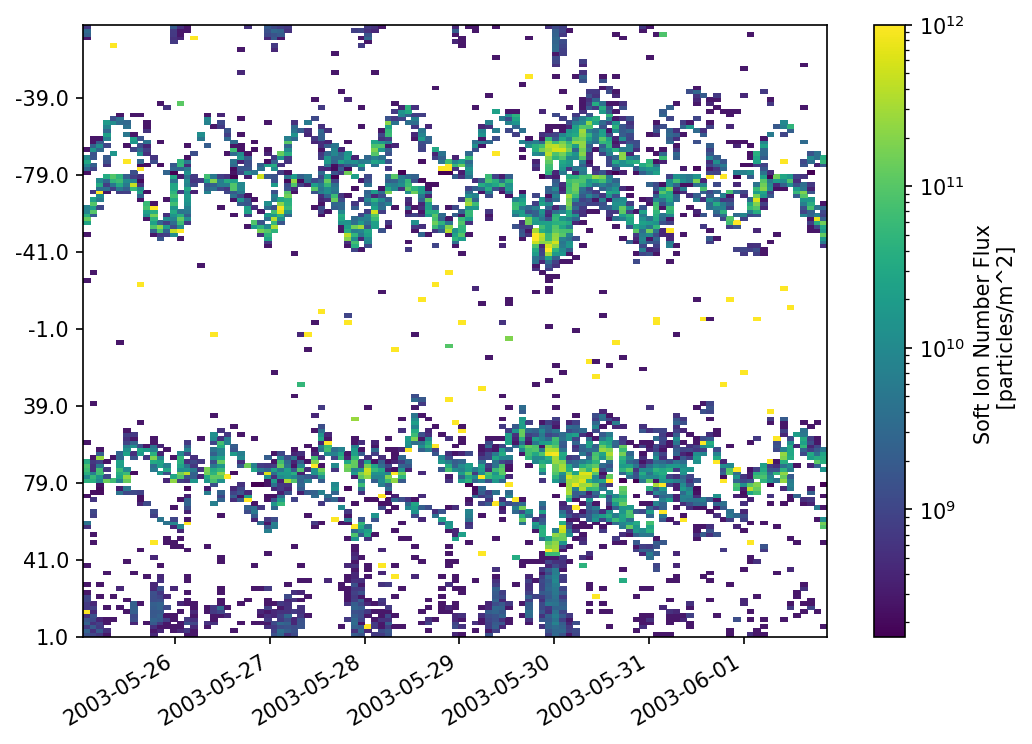

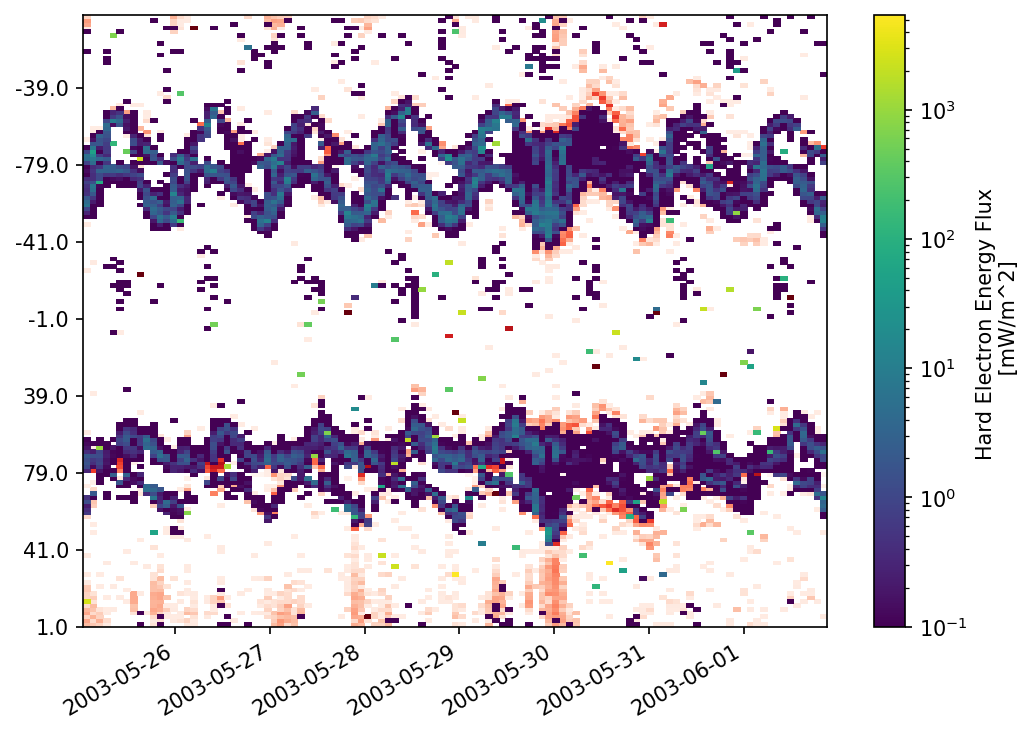

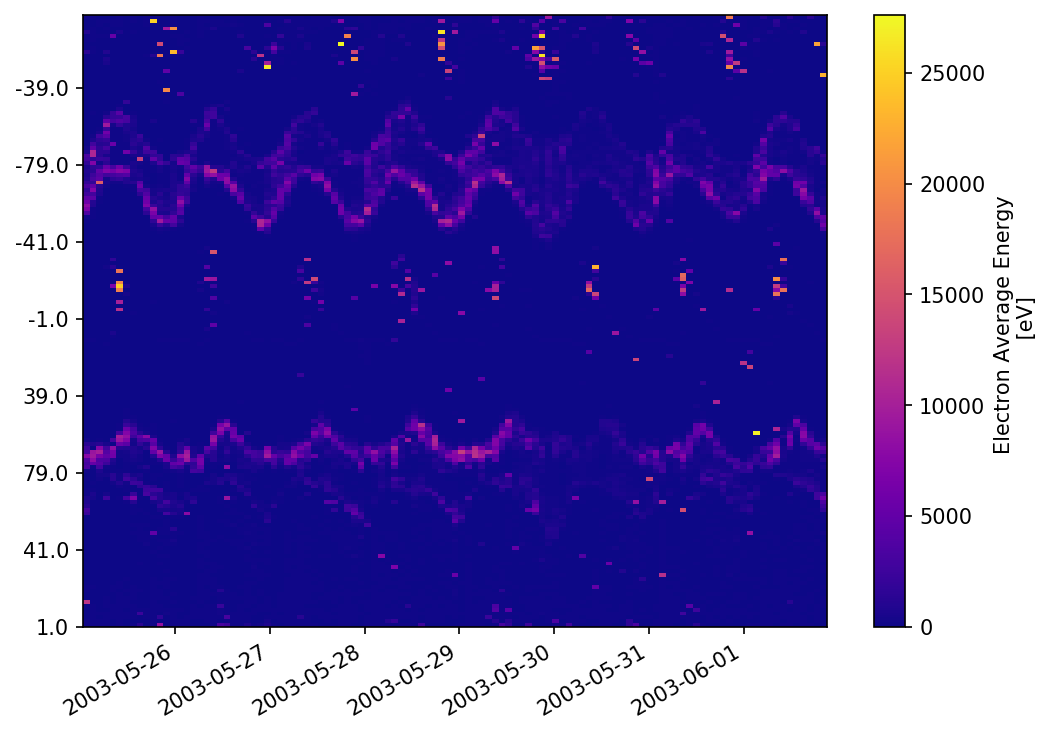

In [8]:
from matplotlib.colors import LogNorm

def latlabel(value,tick_number):
    ilat = int(np.round(value))
    if ilat>=len(lats):
        ilat=len(lats)-1
    return '{}'.format(lats[ilat])

N = lats > 0
f = plt.figure(figsize=(8,6),dpi=150)
ax = f.add_subplot(111)
mappable = ax.pcolormesh(t,np.arange(lats.size),influxs.T,vmax=1e12,norm=LogNorm())
ax.yaxis.set_major_formatter(plt.FuncFormatter(latlabel))
f.colorbar(mappable,label='Soft Ion Number Flux \n [particles/m^2]')
f.autofmt_xdate()

# f2 = plt.figure(figsize=(8,6),dpi=150)
# ax2 = f2.add_subplot(111)
# mappable = ax2.pcolormesh(t,np.arange(lats.size),influxh.T,vmax=1e12,norm=LogNorm())
# ax2.yaxis.set_major_formatter(plt.FuncFormatter(latlabel))
# f2.colorbar(mappable,label='Hard Ion Number Flux \n [particles/m^2]')
# f2.autofmt_xdate()

f3 = plt.figure(figsize=(8,6),dpi=150)
ax3 = f3.add_subplot(111)
mappable2 = ax3.pcolormesh(t,np.arange(lats.size),influxs.T,vmax=1e12,norm=LogNorm(),cmap='Reds')
mappable = ax3.pcolormesh(t,np.arange(lats.size),eefluxh.T,vmin=.1,norm=LogNorm())
ax3.yaxis.set_major_formatter(plt.FuncFormatter(latlabel))
f3.colorbar(mappable,label='Hard Electron Energy Flux \n [mW/m^2]')
f3.autofmt_xdate()

f4 = plt.figure(figsize=(8,6),dpi=150)
ax4 = f4.add_subplot(111)
mappable = ax4.pcolormesh(t,np.arange(lats.size),eavg.T,cmap='plasma')
ax4.yaxis.set_major_formatter(plt.FuncFormatter(latlabel))
f4.colorbar(mappable,label='Electron Average Energy \n [eV]')
f4.autofmt_xdate()